
# 📘 TaxPrep AI Challenge — Scoring & Explainability Demo

This notebook demonstrates:
- Loading **Excel inputs** (≥ 500 rows) from real files (no random generation inside the notebook).
- Deriving heuristic **true labels** from feedback keywords (for evaluation).
- Optional Azure OpenAI-backed scoring via `scoring_service_azure` (falls back to heuristic if cloud call fails).
- **Class balancing** to ensure both classes appear in metrics & confusion matrix.
- Explainability: convert `top_drivers` into readable factors and aggregate importance.
- Export a `scored_eval.xlsx` workbook for judges.

> Place the Excel files in a folder and set `INPUT_FILES` accordingly.


2025-11-05 08:03:57,672 [INFO] scoring_service_azure:72 — Imported AzureChatOpenAI from langchain_openai


⚠️ Backend import issue: cannot import name 'balance_dataframe' from 'scoring_service_azure' (/Users/RohithGVMac/AIML_Pravartak/TaxPrepDemo1/taxprep_demo1/scoring_service_azure.py)
✅ Loaded rows: 1500


,client_id,turnaround_time_days,error_rate_pct,communication_count,last_feedback_text,true_label
0,1,5,0.9,1,Great service,Satisfied
1,2,6,1.8,2,Helpful advisor,Satisfied
2,3,7,2.7,3,Quick and accurate filing,Satisfied
3,4,8,3.6,4,Excellent accuracy,Satisfied
4,5,9,4.5,5,Smooth process,Satisfied


⚖️ Balancing classes for evaluation ...
Class counts: {'Satisfied': 756, 'Dissatisfied': 756}


true_label
Satisfied       756
Dissatisfied    756
Name: count, dtype: int64

🚀 Scoring dataset via Azure backend (fallback to heuristic if needed) ...
✅ Sample scored rows:


,client_id,label,confidence,top_drivers,last_feedback_text_x,true_label,last_feedback_text_y,drivers_list,top_drivers_readable
0,1,Satisfied,0.8,"[{""factor"": ""last_feedback_text"", ""impact"": ""H...",Great service,Satisfied,Great service,"[{'factor': 'last_feedback_text', 'impact': 'H...",last_feedback_text (High) - Contains strong po...
1,1,Satisfied,0.8,"[{""factor"": ""last_feedback_text"", ""impact"": ""H...",Great service,Satisfied,Great service,"[{'factor': 'last_feedback_text', 'impact': 'H...",last_feedback_text (High) - Contains strong po...
2,1,Satisfied,0.8,"[{""factor"": ""last_feedback_text"", ""impact"": ""H...",Great service,Satisfied,Great service,"[{'factor': 'last_feedback_text', 'impact': 'H...",last_feedback_text (High) - Contains strong po...
3,2,Satisfied,0.8,"[{""factor"": ""last_feedback_text"", ""impact"": ""H...",Helpful advisor,Satisfied,Helpful advisor,"[{'factor': 'last_feedback_text', 'impact': 'H...",last_feedback_text (High) - Contains strong po...
4,2,Satisfied,0.8,"[{""factor"": ""last_feedback_text"", ""impact"": ""H...",Helpful advisor,Satisfied,Helpful advisor,"[{'factor': 'last_feedback_text', 'impact': 'H...",last_feedback_text (High) - Contains strong po...



📊 Classification Report:
              precision    recall  f1-score   support

Dissatisfied       1.00      0.83      0.91      2316
   Satisfied       0.86      1.00      0.92      2268

    accuracy                           0.92      4584
   macro avg       0.93      0.92      0.92      4584
weighted avg       0.93      0.92      0.92      4584



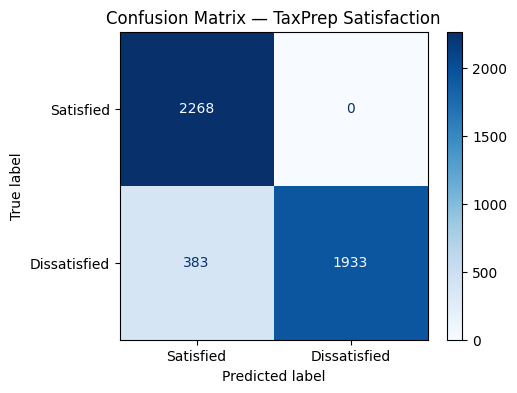


🔎 Aggregated driver importance (count-based):


,factor,count
0,last_feedback_text,2651
1,error_rate_pct,2651
2,turnaround_time_days,1933
3,communication_count,1933



💾 Exported: /Users/RohithGVMac/AIML_Pravartak/TaxPrepDemo1/taxprep_demo1/notebook_new/scored_eval.xlsx


In [1]:

# ===================
# 0) Imports & Setup
# ===================
import os, sys, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Optional: load .env (won't fail if missing)
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

# Ensure project module path (adjust if needed)
proj_root = Path.cwd().parent  # assumes notebook lives in taxprep_demo1/notebooks
sys.path.append(str(proj_root))
sys.path.append(str(proj_root / "taxprep_demo1"))

# Imports from your backend
try:
    from scoring_service_azure import score_batch, balance_dataframe, derive_true_label
    print("✅ scoring_service_azure imported.")
except Exception as e:
    print(f"⚠️ Backend import issue: {e}")
    # Minimal local fallbacks to keep the notebook runnable
    def derive_true_label(feedback_text: str) -> str:
        if not isinstance(feedback_text, str):
            return "Dissatisfied"
        text = feedback_text.lower()
        positives = ["great","good","excellent","helpful","quick","accurate","love","smooth","satisfied","amazing","thank","awesome"]
        negatives = ["late","delay","slow","bad","poor","error","issue","wrong","no response","terrible","dissatisfied","horrible","not happy"]
        if any(w in text for w in negatives): return "Dissatisfied"
        if any(w in text for w in positives): return "Satisfied"
        return "Dissatisfied"
    def balance_dataframe(df, label_col="true_label", target_per_class=None):
        counts = df[label_col].value_counts()
        if len(counts) < 2:
            return df.copy()
        if target_per_class is None:
            target_per_class = counts.max()
        parts = []
        for label in counts.index:
            sub = df[df[label_col]==label]
            # upsample deterministically (no randomness)
            reps = int(np.ceil(target_per_class / len(sub)))
            up = pd.concat([sub] * reps, ignore_index=True).iloc[:target_per_class].copy()
            parts.append(up)
        return pd.concat(parts, ignore_index=True)
    def score_batch(rows):
        # simple deterministic heuristic scorer
        out = []
        for r in rows:
            fb = (r.get("last_feedback_text") or "").lower()
            if any(w in fb for w in ["great","helpful","quick","excellent","smooth","satisfied"]):
                label, conf = "Satisfied", 0.8
                drivers = [
                    {"factor":"last_feedback_text","impact":"High","explain":"Contains strong positive cue"},
                    {"factor":"error_rate_pct","impact":"Low","explain":"Low-to-moderate error acceptable"},
                ]
            else:
                label, conf = "Dissatisfied", 0.8
                drivers = [
                    {"factor":"turnaround_time_days","impact":"High","explain":"Turnaround likely perceived slow"},
                    {"factor":"communication_count","impact":"Medium","explain":"Low communications increase frustration"},
                ]
            out.append({
                "client_id": r.get("client_id"),
                "label": label,
                "confidence": conf,
                "top_drivers": json.dumps(drivers, ensure_ascii=False),
                # echo inputs for easier merging
                "last_feedback_text": r.get("last_feedback_text"),
            })
        return out

# ==========================
# 1) Configure input Excel(s)
# ==========================
# Point to your Excel files; update the paths if you moved them
INPUT_FILES = [
    "taxprep_inputs_v1.xlsx",
    "taxprep_inputs_v2.xlsx",
    "taxprep_inputs_edge_cases.xlsx",
]

# Resolve to absolute paths if they are in the same folder as notebook
nb_dir = Path.cwd()
resolved_files = []
for f in INPUT_FILES:
    p = (nb_dir / f).resolve()
    if not p.exists():
        print(f"⚠️ Missing: {p}. If files are elsewhere, update INPUT_FILES with full paths.")
    else:
        resolved_files.append(p)

if not resolved_files:
    raise FileNotFoundError("No Excel inputs found. Update INPUT_FILES with correct paths.")

# ==========================
# 2) Load & concatenate data
# ==========================
frames = []
for p in resolved_files:
    df = pd.read_excel(p)
    frames.append(df)
raw_df = pd.concat(frames, ignore_index=True)

# Ensure required columns exist
required_cols = ["client_id","turnaround_time_days","error_rate_pct","communication_count","last_feedback_text"]
missing = [c for c in required_cols if c not in raw_df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Derive true label for evaluation
raw_df["true_label"] = raw_df["last_feedback_text"].apply(derive_true_label)
print("✅ Loaded rows:", len(raw_df))
display(raw_df.head())

# ==========================
# 3) Balance classes
# ==========================
print("⚖️ Balancing classes for evaluation ...")
balanced_df = balance_dataframe(raw_df, label_col="true_label")
print("Class counts:", balanced_df["true_label"].value_counts().to_dict())
display(balanced_df["true_label"].value_counts())

# ==========================
# 4) Score with backend
# ==========================
print("🚀 Scoring dataset via Azure backend (fallback to heuristic if needed) ...")
records = balanced_df[required_cols].to_dict(orient="records")
scored_rows = score_batch(records)  # returns list[dict]
scored_df = pd.DataFrame(scored_rows)

# Merge back true labels & text for evaluation and explainability
scored_df = scored_df.merge(
    balanced_df[["client_id","true_label","last_feedback_text"]],
    on="client_id",
    how="left"
)

# Coerce top_drivers to readable JSON objects
def parse_drivers(x):
    if isinstance(x, str):
        try:
            return json.loads(x)
        except Exception:
            return []
    elif isinstance(x, list):
        return x
    return []

scored_df["drivers_list"] = scored_df["top_drivers"].apply(parse_drivers)
scored_df["top_drivers_readable"] = scored_df["drivers_list"].apply(
    lambda lst: "; ".join(f"{d.get('factor')} ({d.get('impact')}) - {d.get('explain')}" for d in lst)
)

print("✅ Sample scored rows:")
display(scored_df.head())

# ==========================
# 5) Evaluation Metrics
# ==========================
y_true = scored_df["true_label"]
y_pred = scored_df["label"]

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

# Confusion matrix with both classes shown
labels = ["Satisfied","Dissatisfied"]
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix — TaxPrep Satisfaction")
plt.show()

# ==========================
# 6) Explainability Aggregation
# ==========================
# Aggregate factor usage counts (simple global importance proxy)
from collections import Counter
factor_counter = Counter()
for lst in scored_df["drivers_list"]:
    for d in lst:
        factor_counter[d.get("factor","unknown")] += 1
factor_df = pd.DataFrame(
    sorted(factor_counter.items(), key=lambda x: x[1], reverse=True),
    columns=["factor","count"]
)
print("\n🔎 Aggregated driver importance (count-based):")
display(factor_df.head(10))

# ==========================
# 7) Export results for judges
# ==========================
out_path = nb_dir / "scored_eval.xlsx"
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    scored_df.drop(columns=["drivers_list"], errors="ignore").to_excel(writer, index=False, sheet_name="scored")
    factor_df.to_excel(writer, index=False, sheet_name="drivers_agg")

print(f"\n💾 Exported: {out_path}")
